In [16]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from catboost import CatBoostRegressor

# Displaying pd Dataframe options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

%matplotlib inline

In [2]:
%%time
# Get datas from pickle
train_df = pd.read_pickle('train_df.pickle')
test_df = pd.read_pickle('test_df.pickle')
test_df['transactionRevenue'] = np.nan

full_df = pd.concat([train_df, test_df], axis=0)

full_df['date'] = pd.to_datetime(full_df['date'], format='%Y%m%d')
full_df['weekday'] = full_df['date'].dt.weekday_name
full_df['day_off'] = (full_df['date'].dt.dayofweek > 4).astype(int)



CPU times: user 6.78 s, sys: 3.1 s, total: 9.88 s
Wall time: 10.3 s


In [3]:
count_user_by_visits = {}
def check_count_by_visits(Id):
    if Id in count_user_by_visits:
        count_user_by_visits[Id]+= 1
    else:
        count_user_by_visits[Id]= 1
    
    return count_user_by_visits[Id]

full_df['visit_index'] = [check_count_by_visits(user) for user in full_df['fullVisitorId']]

In [4]:
cat_features = ['channelGrouping','isMobile','browser','deviceCategory','operatingSystem',
               'country','region','subContinent','networkDomain','continent','newVisits',
               'medium', 'isTrueDirect', 'source', 'isVideoAd', 'slot','page', 'day_off', 
                'weekday']
num_features = ['visitNumber','pageviews','hits', 'visit_index']

In [5]:
full_df[num_features] = full_df[num_features].replace('no_key', 0).fillna(0)
full_df[cat_features] = full_df[cat_features].fillna('other')

In [6]:
X_train, X_test = full_df[full_df['transactionRevenue'] >= 0], full_df[~(full_df['transactionRevenue'] >= 0)]
y_train = X_train['transactionRevenue']

X_train, X_test = X_train[cat_features+num_features], X_test[['fullVisitorId']+cat_features+num_features]

In [7]:
categorical_features=[i for i, x in enumerate(X_train.columns) if x in cat_features]

In [24]:
# 13) Интегрировать код в блок с обучением катбуста. Для снижения снижения лернрейта
def down_iter(size):
    if size == 1:
        return [1]
    if size == 2:
        return [0.5,0.5]
    
    prev_arr = down_iter(size-1)[:-1]
    next_value = (1 - sum(prev_arr)) / 2
    return prev_arr + [next_value] * 2

def train_catboost(model, X, y, cat_features, lr_down_rate=2):
    iterations = model.get_params()['iterations']
    learning_rate = model.get_params()['learning_rate']
    bounds = np.array(down_iter(lr_down_rate))
    lr_arr = [learning_rate / (1.9 ** i) for i in range(lr_down_rate)]
    iter_arr = (bounds * iterations).astype(int) 
    n_trees_count = 0
    for n_trees, lr in zip(iter_arr, lr_arr):
        n_trees_count += n_trees
        print(n_trees, lr)
        model.set_params(iterations=n_trees_count, learning_rate=lr)
        model.fit(X, y, cat_features=cat_features)
    return model

#### Модель регрессии

In [49]:
model_Cat = CatBoostRegressor(iterations=150, thread_count=4, learning_rate=0.1,
                             depth=6, border_count=100, has_time=True,
                             counter_calc_method='Full', save_snapshot=True)

model_Cat = train_catboost(model_Cat, X_train, y_train, cat_features=categorical_features, lr_down_rate=1) 

150 0.1
Can't load progress from file: catboost_info/experiment.cbsnapshot exception: (TCatboostException) catboost/libs/algo/learn_context.cpp:205: Saved model's Params are different from current model's params
0:	learn: 1.9608909	total: 2.43s	remaining: 6m 2s
1:	learn: 1.9145542	total: 4.83s	remaining: 5m 57s
2:	learn: 1.8759639	total: 7.4s	remaining: 6m 2s
3:	learn: 1.8434812	total: 9.58s	remaining: 5m 49s
4:	learn: 1.8159648	total: 11.4s	remaining: 5m 31s
5:	learn: 1.7936021	total: 13.8s	remaining: 5m 31s
6:	learn: 1.7742357	total: 15.9s	remaining: 5m 24s
7:	learn: 1.7579557	total: 18.2s	remaining: 5m 22s
8:	learn: 1.7441967	total: 20.2s	remaining: 5m 16s
9:	learn: 1.7330787	total: 22.3s	remaining: 5m 12s
10:	learn: 1.7231927	total: 24.1s	remaining: 5m 4s
11:	learn: 1.7149309	total: 26.2s	remaining: 5m
12:	learn: 1.7071812	total: 28.2s	remaining: 4m 56s
13:	learn: 1.7004830	total: 30.2s	remaining: 4m 53s
14:	learn: 1.6943586	total: 32.1s	remaining: 4m 48s
15:	learn: 1.6894524	total

#### Модель бинарной классификации

In [57]:
from catboost import CatBoostClassifier

y_train_bin = (y_train > 0).astype(int)
model_Cat_bin = CatBoostClassifier(iterations=100, thread_count=4, learning_rate=0.03,
                             depth=7, border_count=100, has_time=True,
                             counter_calc_method='SkipTest', save_snapshot=True, class_weights=(sum(y_train_bin)/len(y_train_bin), 1-sum(y_train_bin)/len(y_train_bin)))

model_Cat_bin = train_catboost(model_Cat_bin, X_train, y_train_bin, cat_features=categorical_features, lr_down_rate=1) 

100 0.03
Can't load progress from file: catboost_info/experiment.cbsnapshot exception: (TCatboostException) catboost/libs/algo/learn_context.cpp:205: Saved model's Params are different from current model's params
0:	learn: 0.6226639	total: 2.36s	remaining: 3m 53s
1:	learn: 0.5589935	total: 4.47s	remaining: 3m 39s
2:	learn: 0.5064931	total: 6.38s	remaining: 3m 26s
3:	learn: 0.4606892	total: 8.43s	remaining: 3m 22s
4:	learn: 0.4214333	total: 10.7s	remaining: 3m 22s
5:	learn: 0.3881492	total: 12.6s	remaining: 3m 16s
6:	learn: 0.3597156	total: 14.4s	remaining: 3m 11s
7:	learn: 0.3352063	total: 16.4s	remaining: 3m 8s
8:	learn: 0.3136934	total: 18.6s	remaining: 3m 7s
9:	learn: 0.2953869	total: 21.1s	remaining: 3m 10s
10:	learn: 0.2789797	total: 23.2s	remaining: 3m 7s
11:	learn: 0.2642297	total: 25.2s	remaining: 3m 4s
12:	learn: 0.2517777	total: 27s	remaining: 3m
13:	learn: 0.2395987	total: 29.1s	remaining: 2m 58s
14:	learn: 0.2289870	total: 31s	remaining: 2m 55s
15:	learn: 0.2202477	total: 3

In [58]:
y_train_pred = model_Cat_bin.predict_proba(X_train)[:,1]
y_train_true = (y_train > 0).astype(int)

#### Строим графики, подбираем пороги

Average precision-recall score: 0.43


Text(0.5,1,'2-class Precision-Recall curve: AP=0.43')

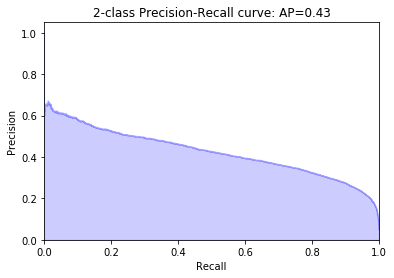

In [59]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_train_true, y_train_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_train_true, y_train_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [60]:
y_bin_pred = model_Cat_bin.predict_proba(X_test.iloc[:,1:])[:,1]

X_test['prediction'] = model_Cat.predict(X_test.iloc[:,1:])
X_test['prediction'] = X_test['prediction']*(X_test['prediction'] >= 0)
X_test['prediction'] = (np.exp(X_test['prediction']) - 1)*y_bin_pred
pred_dict = dict(X_test.groupby('fullVisitorId')['prediction'].sum())

In [47]:
subm = pd.read_csv('sample_submission.csv')
subm['PredictedLogRevenue'] = subm['fullVisitorId'].map(pred_dict).fillna(0)
subm['PredictedLogRevenue'] = np.log(subm['PredictedLogRevenue']+1)
subm.to_csv('sixth_subm.csv', sep=',', index=None)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a6cc3390>]],
      dtype=object)

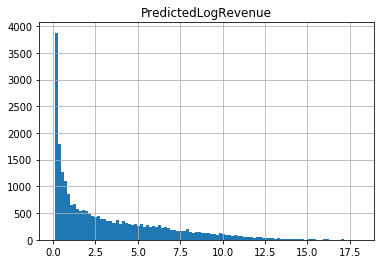

In [48]:
%matplotlib inline
subm[subm['PredictedLogRevenue'] >= 0.1].hist(bins=100)

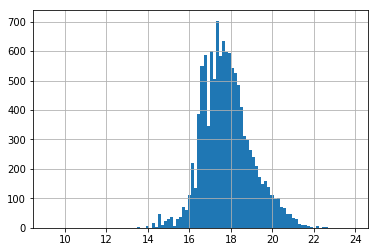

In [78]:
%matplotlib inline
full_df.fillna(0)[full_df['transactionRevenue'].fillna(0) >= 0.1]['transactionRevenue'].hist(bins=100)